# 1. Изучим общую информацию и подготовим данные

Импортируем нужные нам библиотеки для последующего анализа и посмотрим на таблицы

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt 

In [5]:
import numpy as np

In [6]:
from scipy import stats as st

In [7]:
df_calls = pd.read_csv('/datasets/calls.csv')

In [8]:
df_internet = pd.read_csv('/datasets/internet.csv')

In [9]:
df_messages = pd.read_csv('/datasets/messages.csv')

In [10]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')

In [11]:
df_users = pd.read_csv('/datasets/users.csv')

In [12]:
df_calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [13]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Необходимо посчитать сумму звонков и количество минут по месяцам каждого пользователя. Для начала сменим формат столбца call_date и сменим его на конкретный месяц

In [14]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%d')

In [15]:
df_calls['call_month'] = df_calls['call_date'].dt.month

Так как компания всегда округляет вверх значения минут, то округлим значения столбца duration. После этого сгруппируем данные по звонкам

In [16]:
df_calls['duration'] = np.ceil(df_calls['duration'])

In [18]:
calls_group = df_calls.groupby(['user_id', 'call_month'])[['duration']].agg(['count', 'sum']).reset_index()

In [19]:
calls_group

user_id call_month duration       
                           count    sum
0       1000          5       22  159.0
1       1000          6       43  172.0
2       1000          7       47  340.0
3       1000          8       52  408.0
4       1000          9       58  466.0
...      ...        ...      ...    ...
3169    1498         10       41  247.0
3170    1499          9        9   70.0
3171    1499         10       68  449.0
3172    1499         11       74  612.0
3173    1499         12       69  492.0

[3174 rows x 4 columns]

In [20]:
calls_group.columns = ['user_id', 'month', 'count', 'calls_sum']

Теперь необходимо добавить названия тарифов, цену за тарифы, лимит и цену за превышения лимита. Всё это есть в датафреймах df_users и df_tariffs

In [21]:
df_users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [22]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В столбце churn_date, который означает дату прекращения пользования тарифом, замечены пропущенные значения. Т.к. данный столбец не понадобиться нам для дальнейшего анализа, его можно удалить. Также объединим две таблицы по названию тарифа, предварительно сменив название столбца у df_users

In [23]:
df_users = df_users.drop(columns = ['churn_date'])

In [24]:
df_users = df_users.rename(columns = {'tariff':'tariff_name'})

In [25]:
df_users = df_users.merge(df_tariffs, how = 'left', on = 'tariff_name')

Теперь объединим полученную таблицу с нашей сгруппированной таблицей со звонками

In [26]:
df_users_calls = df_users.merge(calls_group, how = 'left', on = 'user_id')

Выделим из таблицы только самые нужные столбцы, для того чтобы найти выручку

In [27]:
df_users_calls = df_users_calls[['user_id', 'city', 'tariff_name', 'rub_monthly_fee', 'rub_per_minute',
                                 'minutes_included', 'month', 'count', 'calls_sum']]

In [28]:
df_users_calls.head(10)

,user_id,city,tariff_name,rub_monthly_fee,rub_per_minute,minutes_included,month,count,calls_sum
0,1000,Краснодар,ultra,1950,1,3000,5.0,22.0,159.0
1,1000,Краснодар,ultra,1950,1,3000,6.0,43.0,172.0
2,1000,Краснодар,ultra,1950,1,3000,7.0,47.0,340.0
3,1000,Краснодар,ultra,1950,1,3000,8.0,52.0,408.0
4,1000,Краснодар,ultra,1950,1,3000,9.0,58.0,466.0
5,1000,Краснодар,ultra,1950,1,3000,10.0,57.0,350.0
6,1000,Краснодар,ultra,1950,1,3000,11.0,43.0,338.0
7,1000,Краснодар,ultra,1950,1,3000,12.0,46.0,333.0
8,1001,Москва,smart,550,3,500,11.0,59.0,430.0
9,1001,Москва,smart,550,3,500,12.0,63.0,414.0


Теперь необходимо найти остаток от превышения тарифа и добавить его в выручку

In [29]:
df_users_calls['remains'] = df_users_calls['calls_sum'] - df_users_calls['minutes_included']

In [30]:
def calls(row):
    if row['remains'] <= 0:
        return 0
    if row['remains'] > 0:
        return (row['rub_per_minute'] * row['remains'])

In [31]:
df_users_calls['calls_revenue'] = df_users_calls.apply(calls, axis = 1)

In [32]:
df_users_calls

,user_id,city,tariff_name,rub_monthly_fee,rub_per_minute,minutes_included,month,count,calls_sum,remains,calls_revenue
0,1000,Краснодар,ultra,1950,1,3000,5.0,22.0,159.0,-2841.0,0.0
1,1000,Краснодар,ultra,1950,1,3000,6.0,43.0,172.0,-2828.0,0.0
2,1000,Краснодар,ultra,1950,1,3000,7.0,47.0,340.0,-2660.0,0.0
3,1000,Краснодар,ultra,1950,1,3000,8.0,52.0,408.0,-2592.0,0.0
4,1000,Краснодар,ultra,1950,1,3000,9.0,58.0,466.0,-2534.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3177,1498,Владикавказ,smart,550,3,500,10.0,41.0,247.0,-253.0,0.0
3178,1499,Пермь,smart,550,3,500,9.0,9.0,70.0,-430.0,0.0
3179,1499,Пермь,smart,550,3,500,10.0,68.0,449.0,-51.0,0.0
3180,1499,Пермь,smart,550,3,500,11.0,74.0,612.0,112.0,336.0


Теперь тоже самое сделаем с сообщениями и интернетом, для того чтобы посчитать уже итоговую выручку по месяцам с каждого пользователя. Начнём с количества отправленных сообщений

In [33]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [34]:
df_messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [35]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d')

In [36]:
df_messages['message_month'] = df_messages['message_date'].dt.month

In [37]:
messages_group = df_messages.groupby(['user_id', 'message_month'])[['message_month']].agg(['count']).reset_index()

In [38]:
messages_group

user_id message_month      
                           count
0       1000             5    22
1       1000             6    60
2       1000             7    75
3       1000             8    81
4       1000             9    57
...      ...           ...   ...
2712    1498            10    42
2713    1499             9    11
2714    1499            10    48
2715    1499            11    59
2716    1499            12    66

[2717 rows x 3 columns]

In [39]:
messages_group.columns = ['user_id', 'month', 'message_count']

In [40]:
df_users_messages = df_users.merge(messages_group, how = 'left', on = ['user_id'])

In [41]:
df_users_messages = df_users_messages[['user_id', 'city', 'tariff_name', 'rub_monthly_fee', 'rub_per_message',
                                       'messages_included', 'month', 'message_count']]

In [42]:
df_users_messages

,user_id,city,tariff_name,rub_monthly_fee,rub_per_message,messages_included,month,message_count
0,1000,Краснодар,ultra,1950,1,1000,5.0,22.0
1,1000,Краснодар,ultra,1950,1,1000,6.0,60.0
2,1000,Краснодар,ultra,1950,1,1000,7.0,75.0
3,1000,Краснодар,ultra,1950,1,1000,8.0,81.0
4,1000,Краснодар,ultra,1950,1,1000,9.0,57.0
...,...,...,...,...,...,...,...,...
2786,1498,Владикавказ,smart,550,3,50,10.0,42.0
2787,1499,Пермь,smart,550,3,50,9.0,11.0
2788,1499,Пермь,smart,550,3,50,10.0,48.0
2789,1499,Пермь,smart,550,3,50,11.0,59.0


In [43]:
df_users_messages['remains'] = df_users_messages['message_count'] - df_users_messages['messages_included']

In [44]:
def messages(row):
    if row['remains'] <= 0:
        return 0
    if row['remains'] > 0:
        return (row['rub_per_message'] * row['remains'])

In [45]:
df_users_messages['message_revenue'] = df_users_messages.apply(messages, axis = 1)

In [46]:
df_users_messages

,user_id,city,tariff_name,rub_monthly_fee,rub_per_message,messages_included,month,message_count,remains,message_revenue
0,1000,Краснодар,ultra,1950,1,1000,5.0,22.0,-978.0,0.0
1,1000,Краснодар,ultra,1950,1,1000,6.0,60.0,-940.0,0.0
2,1000,Краснодар,ultra,1950,1,1000,7.0,75.0,-925.0,0.0
3,1000,Краснодар,ultra,1950,1,1000,8.0,81.0,-919.0,0.0
4,1000,Краснодар,ultra,1950,1,1000,9.0,57.0,-943.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2786,1498,Владикавказ,smart,550,3,50,10.0,42.0,-8.0,0.0
2787,1499,Пермь,smart,550,3,50,9.0,11.0,-39.0,0.0
2788,1499,Пермь,smart,550,3,50,10.0,48.0,-2.0,0.0
2789,1499,Пермь,smart,550,3,50,11.0,59.0,9.0,27.0


Теперь переходим к сумме потраченных гигабайт

In [47]:
df_internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


Удалим столбец Unnamed:0, потому что это явно какая то ошибка в выгрузке данных

In [48]:
df_internet = df_internet.drop(['Unnamed: 0'], axis = 'columns')

In [49]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [50]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')

In [51]:
df_internet['session_month'] = df_internet['session_date'].dt.month

Округлим вверх мегабайты по условиям тарифа, а затем переведём эти значения в гигабайты

In [52]:
df_internet['mb_used'] = np.ceil(df_internet['mb_used'])

In [53]:
df_internet['gb_used'] = (df_internet['mb_used'] / 1000)

In [54]:
internet_group = df_internet.groupby(['user_id', 'session_month'])[['gb_used']].agg(['count', 'sum']).reset_index()

In [55]:
internet_group

user_id session_month gb_used        
                             count     sum
0       1000             5       5   2.256
1       1000             6      49  23.257
2       1000             7      29  14.016
3       1000             8      29  14.070
4       1000             9      27  14.581
...      ...           ...     ...     ...
3198    1498            10      59  20.604
3199    1499             9       5   1.848
3200    1499            10      58  17.809
3201    1499            11      49  17.984
3202    1499            12      45  13.077

[3203 rows x 4 columns]

In [56]:
internet_group.columns = ['user_id', 'month', 'count_gb_used', 'sum_gb_used']

In [57]:
df_users_internet = df_users.merge(internet_group, how = 'left', on = ['user_id'])

Тарифные лимиты также переведём в гигабайты

In [58]:
df_users_internet['mb_per_month_included'] = (df_users_internet['mb_per_month_included'] / 1000).round()

In [59]:
df_users_internet = df_users_internet.rename(columns = {'mb_per_month_included':'gb_per_month_included'})

In [60]:
df_users_internet = df_users_internet[['user_id', 'city', 'tariff_name', 'rub_monthly_fee', 'rub_per_gb',
                                       'gb_per_month_included', 'month', 'count_gb_used', 'sum_gb_used']]

In [61]:
df_users_internet

,user_id,city,tariff_name,rub_monthly_fee,rub_per_gb,gb_per_month_included,month,count_gb_used,sum_gb_used
0,1000,Краснодар,ultra,1950,150,31.0,5.0,5.0,2.256
1,1000,Краснодар,ultra,1950,150,31.0,6.0,49.0,23.257
2,1000,Краснодар,ultra,1950,150,31.0,7.0,29.0,14.016
3,1000,Краснодар,ultra,1950,150,31.0,8.0,29.0,14.070
4,1000,Краснодар,ultra,1950,150,31.0,9.0,27.0,14.581
...,...,...,...,...,...,...,...,...,...
3201,1498,Владикавказ,smart,550,200,15.0,10.0,59.0,20.604
3202,1499,Пермь,smart,550,200,15.0,9.0,5.0,1.848
3203,1499,Пермь,smart,550,200,15.0,10.0,58.0,17.809
3204,1499,Пермь,smart,550,200,15.0,11.0,49.0,17.984


In [62]:
df_users_internet['remains'] = df_users_internet['sum_gb_used'] - df_users_internet['gb_per_month_included']

In [63]:
def internet(row):
    if row['remains'] <= 0:
        return 0
    if row['remains'] > 0:
        return (row['rub_per_gb'] * row['remains'])

In [64]:
df_users_internet['internet_revenue'] = df_users_internet.apply(internet, axis = 1)

In [65]:
df_users_internet

,user_id,city,tariff_name,rub_monthly_fee,rub_per_gb,gb_per_month_included,month,count_gb_used,sum_gb_used,remains,internet_revenue
0,1000,Краснодар,ultra,1950,150,31.0,5.0,5.0,2.256,-28.744,0.0
1,1000,Краснодар,ultra,1950,150,31.0,6.0,49.0,23.257,-7.743,0.0
2,1000,Краснодар,ultra,1950,150,31.0,7.0,29.0,14.016,-16.984,0.0
3,1000,Краснодар,ultra,1950,150,31.0,8.0,29.0,14.070,-16.930,0.0
4,1000,Краснодар,ultra,1950,150,31.0,9.0,27.0,14.581,-16.419,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3201,1498,Владикавказ,smart,550,200,15.0,10.0,59.0,20.604,5.604,1120.8
3202,1499,Пермь,smart,550,200,15.0,9.0,5.0,1.848,-13.152,0.0
3203,1499,Пермь,smart,550,200,15.0,10.0,58.0,17.809,2.809,561.8
3204,1499,Пермь,smart,550,200,15.0,11.0,49.0,17.984,2.984,596.8


Теперь объединим три таблицы, для того чтобы найти общую выручку

In [66]:
df_final = df_users_calls.merge(df_users_messages, how = 'left', on = ['user_id', 'month', 'tariff_name', 'city'])

In [67]:
df_final = df_final.merge(df_users_internet, how = 'left', on = ['user_id', 'month', 'tariff_name', 'city'])

In [68]:
df_final

,user_id,city,tariff_name,rub_monthly_fee_x,rub_per_minute,minutes_included,month,count,calls_sum,remains_x,...,message_count,remains_y,message_revenue,rub_monthly_fee,rub_per_gb,gb_per_month_included,count_gb_used,sum_gb_used,remains,internet_revenue
0,1000,Краснодар,ultra,1950,1,3000,5.0,22.0,159.0,-2841.0,...,22.0,-978.0,0.0,1950.0,150.0,31.0,5.0,2.256,-28.744,0.0
1,1000,Краснодар,ultra,1950,1,3000,6.0,43.0,172.0,-2828.0,...,60.0,-940.0,0.0,1950.0,150.0,31.0,49.0,23.257,-7.743,0.0
2,1000,Краснодар,ultra,1950,1,3000,7.0,47.0,340.0,-2660.0,...,75.0,-925.0,0.0,1950.0,150.0,31.0,29.0,14.016,-16.984,0.0
3,1000,Краснодар,ultra,1950,1,3000,8.0,52.0,408.0,-2592.0,...,81.0,-919.0,0.0,1950.0,150.0,31.0,29.0,14.070,-16.930,0.0
4,1000,Краснодар,ultra,1950,1,3000,9.0,58.0,466.0,-2534.0,...,57.0,-943.0,0.0,1950.0,150.0,31.0,27.0,14.581,-16.419,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177,1498,Владикавказ,smart,550,3,500,10.0,41.0,247.0,-253.0,...,42.0,-8.0,0.0,550.0,200.0,15.0,59.0,20.604,5.604,1120.8
3178,1499,Пермь,smart,550,3,500,9.0,9.0,70.0,-430.0,...,11.0,-39.0,0.0,550.0,200.0,15.0,5.0,1.848,-13.152,0.0
3179,1499,Пермь,smart,550,3,500,10.0,68.0,449.0,-51.0,...,48.0,-2.0,0.0,550.0,200.0,15.0,58.0,17.809,2.809,561.8
3180,1499,Пермь,smart,550,3,500,11.0,74.0,612.0,112.0,...,59.0,9.0,27.0,550.0,200.0,15.0,49.0,17.984,2.984,596.8


In [69]:
df_final.isna().sum()

user_id                    0
city                       0
tariff_name                0
rub_monthly_fee_x          0
rub_per_minute             0
minutes_included           0
month                      8
count                      8
calls_sum                  8
remains_x                  8
calls_revenue              8
rub_monthly_fee_y        502
rub_per_message          502
messages_included        502
message_count            504
remains_y                504
message_revenue          504
rub_monthly_fee           17
rub_per_gb                17
gb_per_month_included     17
count_gb_used             19
sum_gb_used               19
remains                   19
internet_revenue          19
dtype: int64

Чтобы корректно посчитать выручку, заменим появившиеся значения NaN в интересующих нас местах на нули, т.к. к примеру, некоторые просто не отправляет сообщений пользуясь услугами или кто-то не пользуется интернетом

In [70]:
df_final['calls_revenue'] = df_final['calls_revenue'].fillna(0)

In [71]:
df_final['message_revenue'] = df_final['message_revenue'].fillna(0)

In [72]:
df_final['internet_revenue'] = df_final['internet_revenue'].fillna(0)

У нас также появились строки с NaN в столбце со стоимостью тарифа. Их довольно мало и можно удалить, для того чтобы в выручке не было пропусков

In [73]:
df_final = df_final.dropna(subset = ['rub_monthly_fee'])

Теперь сложим столбцы для определения выручки с каждого пользователя в месяц

In [74]:
df_final['final_revenue'] = df_final['calls_revenue'] + df_final['message_revenue'] + df_final['internet_revenue']\
+ df_final['rub_monthly_fee']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [75]:
df_final = df_final[['user_id', 'city', 'tariff_name', 'month', 'calls_sum', 'message_count', 'sum_gb_used',
                     'final_revenue']]

In [76]:
df_final

,user_id,city,tariff_name,month,calls_sum,message_count,sum_gb_used,final_revenue
0,1000,Краснодар,ultra,5.0,159.0,22.0,2.256,1950.0
1,1000,Краснодар,ultra,6.0,172.0,60.0,23.257,1950.0
2,1000,Краснодар,ultra,7.0,340.0,75.0,14.016,1950.0
3,1000,Краснодар,ultra,8.0,408.0,81.0,14.070,1950.0
4,1000,Краснодар,ultra,9.0,466.0,57.0,14.581,1950.0
...,...,...,...,...,...,...,...,...
3177,1498,Владикавказ,smart,10.0,247.0,42.0,20.604,1670.8
3178,1499,Пермь,smart,9.0,70.0,11.0,1.848,550.0
3179,1499,Пермь,smart,10.0,449.0,48.0,17.809,1111.8
3180,1499,Пермь,smart,11.0,612.0,59.0,17.984,1509.8


### Вывод

Посчитали суммы, объединил таблицы, убрали пропущенные значения и нашли выручку за каждый месяц с каждого пользователя.     Данные подсчитаны и обработаны, теперь можно приступать к анализу.

# 2. Проанализируем данные

Посмотрим, сколько нужно минут пользователям разных тарифов в месяц, построим гистограммы, посчитаем среднее, дисперсию и стандартное отклонение

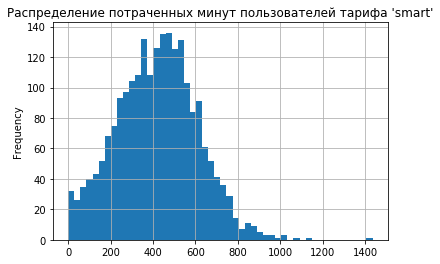

In [77]:
df_final['calls_sum'].loc[df_final['tariff_name'] == 'smart']\
.plot(kind = 'hist',grid = True, bins = 50, title = "Распределение потраченных минут пользователей тарифа 'smart'")

In [78]:
np.var(df_final['calls_sum'].loc[df_final['tariff_name'] == 'smart'], ddof = 1)

35798.97361633957

In [79]:
np.std(df_final['calls_sum'].loc[df_final['tariff_name'] == 'smart'], ddof = 1)

189.2061669617023

In [80]:
df_final['calls_sum'].loc[df_final['tariff_name'] == 'smart'].describe()

count    2222.000000
mean      419.229073
std       189.206167
min         0.000000
25%       285.000000
50%       423.000000
75%       545.750000
max      1435.000000
Name: calls_sum, dtype: float64

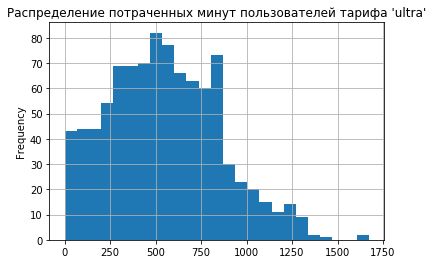

In [81]:
df_final['calls_sum'].loc[df_final['tariff_name'] == 'ultra']\
.plot(kind = 'hist', bins = 25, grid = True, title = "Распределение потраченных минут пользователей тарифа 'ultra'")

In [82]:
np.var(df_final['calls_sum'].loc[df_final['tariff_name'] == 'ultra'], ddof = 1)

94015.42736789743

In [83]:
np.std(df_final['calls_sum'].loc[df_final['tariff_name'] == 'ultra'], ddof = 1)

306.6193525658441

In [84]:
df_final['calls_sum'].loc[df_final['tariff_name'] == 'ultra'].describe()

count     941.000000
mean      548.890542
std       306.619353
min         0.000000
25%       315.000000
50%       531.000000
75%       760.000000
max      1673.000000
Name: calls_sum, dtype: float64

Наглядно сравним два тарифа по количеству потраченных минут

Text(0, 0.5, 'Количество минут')

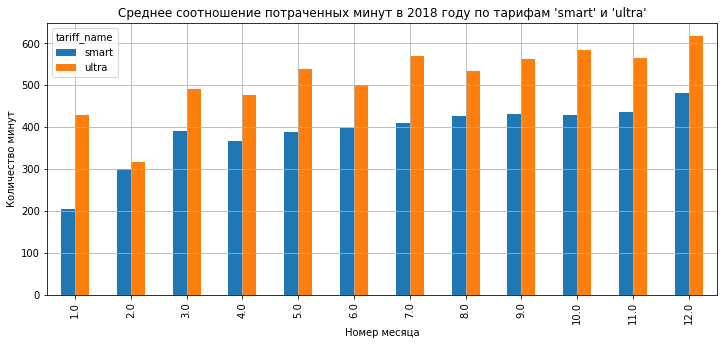

In [85]:
calls_bar = (df_final.pivot_table(index = 'month', columns = 'tariff_name', values = 'calls_sum', aggfunc = 'mean')
 .plot(kind = 'bar', grid = True, figsize = (12,5), 
       title = "Среднее соотношение потраченных минут в 2018 году по тарифам 'smart' и 'ultra'"))

calls_bar.set_xlabel('Номер месяца')
calls_bar.set_ylabel('Количество минут')

С уверенностью можно сказать, что несмотря на большее количество пользователей тарифа 'smart', пользователям тарифа 'ultra' необходимо в месяц больше минут. В среднем смарт тарифу необходимо 419 минут со средним отклонением в 189, тогда как пользователи ультра тарифа тратят в среднем 548 минут с отклонением в 306.

Отметить можно разве что то, что в феврале пользователи обоих тарифов тратят минуты практически одинакого.

Теперь сделаем тоже самое с смс сообщениями

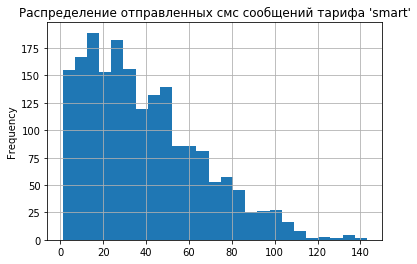

In [86]:
df_final['message_count'].loc[df_final['tariff_name'] == 'smart']\
.plot(kind = 'hist' , bins = 25, grid = True, title = "Распределение отправленных смс сообщений тарифа 'smart'")

In [87]:
np.var(df_final['message_count'].loc[df_final['tariff_name'] == 'smart'], ddof = 1)

718.8036193391555

In [88]:
np.std(df_final['message_count'].loc[df_final['tariff_name'] == 'smart'], ddof = 1)

26.810513224090947

In [89]:
df_final['message_count'].loc[df_final['tariff_name'] == 'smart'].describe()

count    1915.000000
mean       38.767102
std        26.810513
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: message_count, dtype: float64

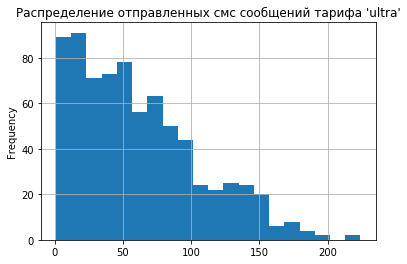

In [90]:
df_final['message_count'].loc[df_final['tariff_name'] == 'ultra']\
.plot(kind = 'hist', bins = 20, grid = True, title = "Распределение отправленных смс сообщений тарифа 'ultra'")

In [91]:
np.var(df_final['message_count'].loc[df_final['tariff_name'] == 'ultra'], ddof = 1)

2008.5500113324078

In [92]:
np.std(df_final['message_count'].loc[df_final['tariff_name'] == 'ultra'], ddof = 1)

44.816849636408044

In [93]:
df_final['message_count'].loc[df_final['tariff_name'] == 'ultra'].describe()

count    752.000000
mean      61.640957
std       44.816850
min        1.000000
25%       25.000000
50%       53.000000
75%       89.000000
max      224.000000
Name: message_count, dtype: float64

Text(0, 0.5, 'Количество отправленных сообщений')

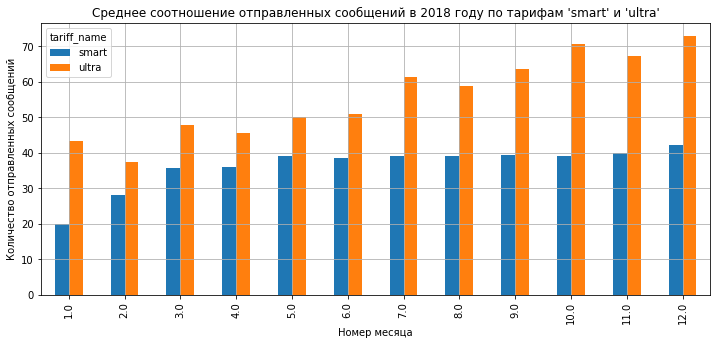

In [94]:
message_bar = (df_final.pivot_table(index = 'month', columns = 'tariff_name', values = 'message_count')
 .plot(kind = 'bar', grid = True, figsize = (12,5), 
       title = "Среднее соотношение отправленных сообщений в 2018 году по тарифам 'smart' и 'ultra'"))

message_bar.set_xlabel('Номер месяца')
message_bar.set_ylabel('Количество отправленных сообщений')

И снова пользователи тарифа ультра впереди. Им в среднем необходимо 62 смс сообщений в месяц со средним отклонением в 45. Смарт пользователям в тоже время в среднем необходимо 39 смс со средним отклонением в 27

Теперь посмотрим на потраченные гигабайты среди всех тарифов

In [95]:
internet_smart = df_users_internet.query('tariff_name == "smart"')

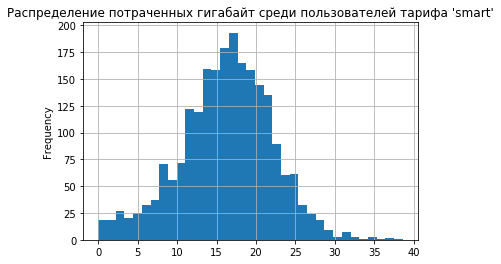

In [96]:
df_final['sum_gb_used'].loc[df_final['tariff_name'] == 'smart']\
.plot(kind = 'hist', bins = 35, grid = True, title = "Распределение потраченных гигабайт среди пользователей тарифа 'smart'")

In [97]:
np.var(df_final['sum_gb_used'].loc[df_final['tariff_name'] == 'smart'], ddof = 1)

34.51088870763467

In [98]:
np.std(df_final['sum_gb_used'].loc[df_final['tariff_name'] == 'smart'], ddof = 1)

5.8745968974589795

In [99]:
df_final['sum_gb_used'].loc[df_final['tariff_name'] == 'smart'].describe()

count    2222.000000
mean       16.237471
std         5.874597
min         0.000000
25%        12.674500
50%        16.529000
75%        20.077000
max        38.610000
Name: sum_gb_used, dtype: float64

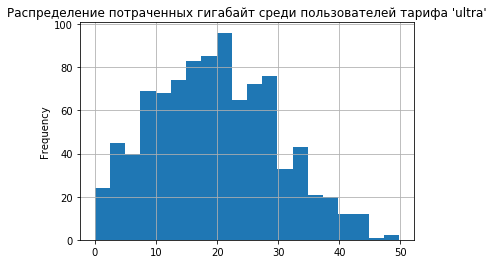

In [100]:
df_final['sum_gb_used'].loc[df_final['tariff_name'] == 'ultra']\
.plot(kind = 'hist', bins = 20, grid = True, title = "Распределение потраченных гигабайт среди пользователей тарифа 'ultra'")

In [101]:
np.var(df_final['sum_gb_used'].loc[df_final['tariff_name'] == 'ultra'], ddof = 1)

99.75081996314923

In [102]:
np.std(df_final['sum_gb_used'].loc[df_final['tariff_name'] == 'ultra'], ddof = 1)

9.98753322713618

In [103]:
df_final['sum_gb_used'].loc[df_final['tariff_name'] == 'ultra'].describe()

count    941.000000
mean      19.687564
std        9.987533
min        0.000000
25%       11.884000
50%       19.446000
75%       26.889000
max       49.789000
Name: sum_gb_used, dtype: float64

Text(0, 0.5, 'Количество интернет трафика, Gb')

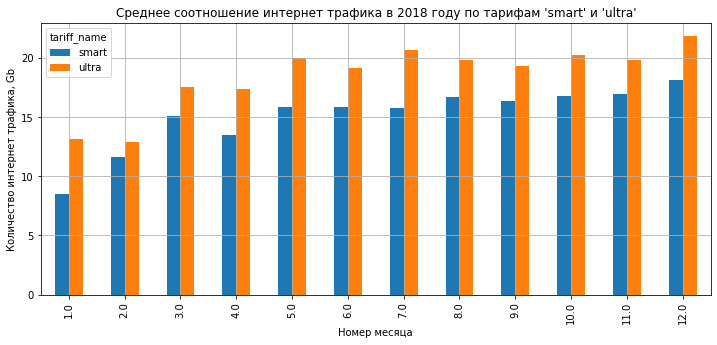

In [104]:
internet_bar = (df_final.pivot_table(index = 'month', columns = 'tariff_name', values = 'sum_gb_used')
 .plot(kind = 'bar', grid = True, figsize = (12,5), 
       title = "Среднее соотношение интернет трафика в 2018 году по тарифам 'smart' и 'ultra'"))

internet_bar.set_xlabel('Номер месяца')
internet_bar.set_ylabel('Количество интернет трафика, Gb')

Пользователи 'smart' тарифа тратят в среднем 16 гигигабайт интернет трафика со средним отклонением в 9 гигабайт, тогда как пользователям тарифа 'ultra' необходимо в среднем 20 гигабайт с отклонением в 10.

Теперь посмотрим на среднюю выручку двух тарифов

Text(0, 0.5, 'Количество интернет трафика, Gb')

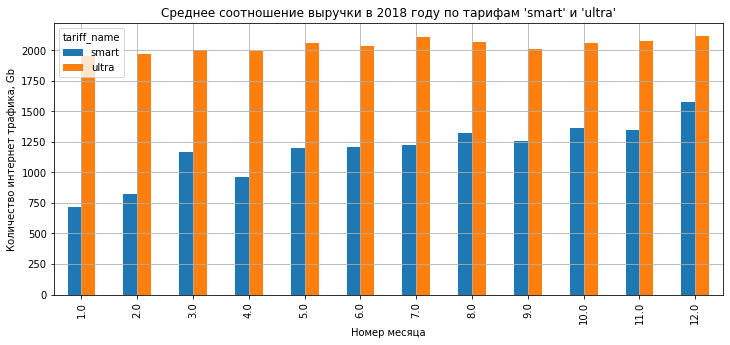

In [105]:
internet_bar = (df_final.pivot_table(index = 'month', columns = 'tariff_name', values = 'final_revenue')
 .plot(kind = 'bar', grid = True, figsize = (12,5), 
       title = "Среднее соотношение выручки в 2018 году по тарифам 'smart' и 'ultra'"))

internet_bar.set_xlabel('Номер месяца')
internet_bar.set_ylabel('Количество интернет трафика, Gb')

### Вывод

В целом можно отметить то, что пользователям тарифа 'ultra' необходимо в месяц больше минут, сообщений и гигабайт, чем пользователям тарифа 'smart'. Вывод довольно очевидный т.к. тариф ультра содержит больше включенных опций, чем другой тариф. Также мы выяснили, что средняя выручка тарифа 'ультра' по всем месяцам больше, чем тарифа 'смарт'.

# 3. Проверим гипотезы

Первая гипотеза звучит так: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
Нулевой гипотезой будем считать то, что средняя выручка двух тарифов равна. Пределом статистической значимости будем считать 5%. Если значение будет меньше альфы, то отвергнем нулевую гипотезу.

В качестве критерия будем использовать тест на основе распределения Стьюдента - t-test

In [106]:
alpha = 0.05

In [107]:
results = st.ttest_ind(df_final['final_revenue'].loc[df_final['tariff_name'] == 'smart'],
                       df_final['final_revenue'].loc[df_final['tariff_name'] == 'ultra'])

In [108]:
results.pvalue

2.0662959133798064e-149

Значение pvalue очень высокое. Нулевую гипотезу не получилось отвергнуть

Теперь проверим вторую гипотезу, которая звучит так: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
Нулевой гипотезой обозначим, что выручка в регионах и Москве одинаковая. За альфу возьмём 5%, если t-test покажет значение меньше пяти процентов, то отвергнем нулевую гипотезу

In [109]:
alpha = 0.05

In [110]:
results_city = st.ttest_ind(df_final['final_revenue'].loc[df_final['city'] == 'Москва'], 
                            df_final['final_revenue'].loc[df_final['city'] != 'Москва'])

In [111]:
results_city.pvalue

0.4959343379424328

Не получилось отвергнуть нулевую гипотезу

### Вывод

В первом случае мы отвергли нулевую гипотезу т.к. она была меньше нашей альфы и равна двум. Это значит, что средняя выручка пользователей двух тарифов врятли будет одинаковой. Во втором случае, шанс на то что вырчка из Москвы и регионов будет совпадать равна 5%. Это говорит о том, что местами средняя выручка по Мосвке и регионам может совпадать, т.к. стоимость тарифов везде одинаковая

## 4. Общий вывод

За 2018 год, несмотря на то, что у тарифа 'ultra' пользователей меньше, чем тарифа 'smart', тариф ультра в среднем принёс  больше выручки, чем его конкурент. Поэтому можно с уверенностью сказать, что для компании "Мегалайн" тариф Ультра является самым прибыльным.